# Interval analysis

### Dario Malchiodi

[malchiodi@di.unimi.it](mailto:malchiodi@di.unimi.it)

## Starting point

- **statistical inference**: having access to only a _part_ of a _population_ (a _sample_, what can be said about some properties of the latter?
- **parametric inference**: how does the problem simplifies if we know the distribution of the population, except for one or more _parameters_?

## First approach: point estimation

Provide a numerical approximation for each parameter using a _statistic_, that is a function of the sample. Keeping it simple, we'll assume the existence of just one parameter to be inferred.

Let's synthesize some data and play around. Pretend these constitute a normally-distributed population of martian heigth, measured in a suitable unit:

In [72]:
mu = 1200
sigma = 37
n = 1000
X = st.norm(mu, sigma)
population = pd.DataFrame(X.rvs(n), columns=['Martian height'])
population.head()

,Martian height
0,1142.864796
1,1296.947837
2,1235.562214
3,1211.098935
4,1196.744847


If we don't have access to the mean of the population (actually we do, because we just synthesized these data, but usually this is not the case; moreover, this will also let us check how far our approximation is from the _real_ value), we can use the _sample mean_ as an approximation:

In [82]:
sample = population['Martian height'].sample(20)
sample.mean()

1212.3587306572351

If we repeatedly compute the estimate from different samples of equal size, of course the result will change each time, as highlighted by the following interactive graph, where the red and green line denote the actual and approximated mean value, respectively.

In [87]:
def show_sample_and_means(sample, mu):
    n = len(sample)
    plt.plot(sample, [0]*n, 'o', ms=4, alpha=0.5)
    plt.plot((sample.min(), sample.max()), (0,0))
    plt.plot(2*[mu], (-.05, .05), c='r')
    plt.plot(2*[sample.mean()], (-.05, .05), c='g')
    plt.ylim(-.2, .2)
    plt.xlim(1150, 1250)
    plt.show()

btn = widgets.Button(description="Once again!")
out = widgets.Output()

def sample_and_compute(b):
    with out:
        clear_output()
        show_sample_and_means(population['Martian height'].sample(20), mu)

btn.on_click(sample_and_compute)
sample_and_compute(btn)
widgets.VBox([btn, out])

VBox(children=(Button(description='Once again!', style=ButtonStyle()), Output()))

It's easy to see that the estimated value oscillates around the actual one. This is an important property of the used statistic, namely its _unbiasedness_. Formally speaking, denoting by $X_1, \dots, X_n$ the random variables associated to the sampled elements, we used as statistic the sample mean

$$ \bar X = \frac{1}{n}\sum_{i=1}^n X_i, $$

whose unbiasedness property ensures that $\mathcal E\left(\bar X\right) = \mu$, where $\mu$ is the mean of the underlying population. There are only a few cases where such a results is independent of the distribution of the population. One such popular case is that of variance, which can be unbiasedly approximated using the so-called _sample variance_

$$ S^2 = \frac{1}{n-1}\sum_{i=1}^n \left(X_i - \bar X\right)^2, $$

where the $\frac{1}{n-1}$ factor ensures the unbiasedness property.

## Second approach: fiducial intervals

Alternative to point estimation: given an unknown quantity $\tau$

- provide an interval $I$ likely containing $\tau$
- and quantiy this likelyhood

## A first example

$$\{ X_1, \dots, X_n\} \text{ sample from } X\sim N(\mu, \sigma)$$

$$\bar X = \frac{1}{n}\sum_{i=1}^n X_i \sim N\left(\mu, \frac{\sigma}{\sqrt{n}}\right)$$

$$Z = \frac{\bar X - \mu}{\frac{\sigma}{\sqrt{n}}} \sim N(0, 1)$$

Fixed $\alpha$, find $z$ such that

$$\mathrm P(|Z|<z) = \alpha $$

In [1]:
%matplotlib inline

from __future__ import print_function

import scipy.stats as st
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets, interact
from IPython.display import display, clear_output

def ci_graph(conf):
    Z = st.norm()
    q = Z.ppf((1+conf)/2)
    xs = np.arange(-q, q+.01, .01)
    plt.plot(xs, Z.pdf(xs))
    left_tail = np.arange(-3, -q+.01, .01)
    right_tail = np.arange(q, 3, .01)
    plt.fill_between(right_tail, 0, Z.pdf(right_tail), facecolor='lightblue')
    plt.fill_between(left_tail, 0, Z.pdf(left_tail), facecolor='lightblue')
    plt.title('$z = {:.2f}$'.format(q))
    plt.text(q+(3-q)/2, Z.pdf(q), r'$\frac{1-\alpha}{2}$', fontsize=25, horizontalalignment='center')
    plt.text(-q-(3-q)/2, Z.pdf(q), r'$\frac{1-\alpha}{2}$', fontsize=25, horizontalalignment='center')
    plt.text(0, .15, r'$\alpha$', fontsize=25, horizontalalignment='center')
    plt.show()

rangeSlider = widgets.FloatSlider(
    value = .95,
    min = .1,
    max = .99,
    step = .01,
    description = 'Confidence',
    continuous_update = True
)

interact(ci_graph, conf=rangeSlider);

interactive(children=(FloatSlider(value=0.95, description='Confidence', max=0.99, min=0.1, step=0.01), Output()), _dom_classes=('widget-interact',))

Let $\chi_p = \Phi^{-1}(p)$ denote the $p$ quantile of $Z$

The answer is

$$ z = \chi_{1-\frac{1-\alpha}{2}} = \chi_{\frac{1+\alpha}{2}} $$

Some reference values:

In [2]:
def HTML_with_style(df, style=None, random_id=None):
    from IPython.display import HTML
    import numpy as np
    import re

    df_html = df.to_html()

    if random_id is None:
        random_id = 'id%d' % np.random.choice(np.arange(1000000))

    if style is None:
        style = """
        <style>
            table#{random_id} {{color: blue}}
        </style>
        """.format(random_id=random_id)
    else:
        new_style = []
        s = re.sub(r'</?style>', '', style).strip()
        for line in s.split('\n'):
                line = line.strip()
                if not re.match(r'^table', line):
                    line = re.sub(r'^', 'table ', line)
                new_style.append(line)
        new_style = ['<style>'] + new_style + ['</style>']

        style = re.sub(r'table(#\S+)?',
                       'table#%s' % random_id, '\n'.join(new_style))

    df_html = re.sub(r'<table', r'<table id=%s ' % random_id, df_html)

    return HTML(style + df_html)

style = """
<style>
    table tr :first-child{display: none;}
</style>
"""

Z = st.norm()
HTML_with_style(pd.DataFrame([('{:.2f}'.format(alpha),
  '{:.2f}'.format(Z.ppf((1+alpha)/2))) for alpha in np.arange(.5, 1, .05)],
            columns=['alpha', 'z']),
                style)

,alpha,z
0,0.50,0.67
1,0.55,0.76
2,0.60,0.84
3,0.65,0.93
4,0.70,1.04
5,0.75,1.15
6,0.80,1.28
7,0.85,1.44
8,0.90,1.64
9,0.95,1.96


Thus

$$\mathrm P(-\chi_{\frac{1+\alpha}{2}} < Z < \chi_{\frac{1+\alpha}{2}}) = 1 - \alpha $$

In [3]:
def inner_ci_graph(conf):
    Z = st.norm()
    q = Z.ppf((1+conf)/2)
    xs = np.arange(-q, q+.01, .01)
    left_tail = np.arange(-3, -q+.01, .01)
    right_tail = np.arange(q, 3, .01)
    plt.plot(right_tail, Z.pdf(right_tail), c='b')
    plt.plot(left_tail, Z.pdf(left_tail), c='b')
    plt.fill_between(xs, 0, Z.pdf(xs), facecolor='lightblue')
    plt.title('$P({:.2f} < Z < {:.2f}) = {:.2f}$'.format(-q, q, conf), fontsize=25)
    plt.show()

rangeSlider = widgets.FloatSlider(
    value = .95,
    min = .1,
    max = .99,
    step = .01,
    description = 'Confidence',
    continuous_update = True
)

interact(inner_ci_graph, conf=rangeSlider);

interactive(children=(FloatSlider(value=0.95, description='Confidence', max=0.99, min=0.1, step=0.01), Output()), _dom_classes=('widget-interact',))

But

$$Z = \frac{\bar X - \mu}{\frac{\sigma}{\sqrt{n}}} \sim N(0, 1)$$

so

$$\mathrm P\left(
    -\chi_{\frac{1+\alpha}{2}} < Z < \chi_{\frac{1+\alpha}{2}}
  \right) = 
  \mathrm P\left(
    \bar X -\chi_{\frac{1+\alpha}{2}} \frac{\sigma}{\sqrt{n}} <
    \mu < \bar X + \chi_{\frac{1+\alpha}{2}} \frac{\sigma}{\sqrt{n}}
  \right) $$

Summing up

$$\mathrm P\left(
    \bar X -\chi_{\frac{1+\alpha}{2}} \frac{\sigma}{\sqrt{n}} <
    \mu < \bar X + \chi_{\frac{1+\alpha}{2}} \frac{\sigma}{\sqrt{n}}
  \right) = \alpha $$
  
Thus

$$\left(\bar X -\chi_{\frac{1+\alpha}{2}} \frac{\sigma}{\sqrt{n}},
       \bar X + \chi_{\frac{1+\alpha}{2}} \frac{\sigma}{\sqrt{n}}\right)$$

is a _confidence interval_ for $\mu$

Let's replace $\alpha$ by $1 - \delta$:

$$ \mathrm P \left(|Z| < \chi_{\frac{1+\alpha}{2}} \right) = \alpha $$

translates to

$$ \mathrm P \left(|Z| < \chi_{1-\frac{\delta}{2}} \right) = 1-\delta $$

and $\chi_{1-\frac{\delta}{2}} = - \chi_{\frac{\delta}{2}}$, thus

$$ \mathrm P\left(
     \bar X +\chi_{\frac{\delta}{2}} \frac{\sigma}{\sqrt{n}} <
     \mu < \bar X - \chi_{\frac{\delta}{2}} \frac{\sigma}{\sqrt{n}}
   \right) = 1-\delta $$
  
Formally speaking

$$ \left(
     \bar X +\chi_{\frac{\delta}{2}} \frac{\sigma}{\sqrt{n}},
     \bar X - \chi_{\frac{\delta}{2}} \frac{\sigma}{\sqrt{n}}
   \right) = 1-\delta $$

is a _confidence interval_ for $\mu = \mathcal E(X)$:

- $1-\delta$: _confidence_ of the interval,
- $\delta$: _confidence level_ of the interval.

For sake of simplicity, let's also build a function computing generic confidence intervals for the mean of a gaussian variable.

In [5]:
def ci_mu_norm(sigma, delta, sample):
    Z = st.norm()
    x_bar = sample.mean()
    chi = Z.ppf(delta/2)
    n = len(sample)
    confidence_interval = (x_bar + chi * sigma / math.sqrt(n),
                           x_bar - chi * sigma / math.sqrt(n))

    return confidence_interval

Just to check out that everything works, we can sample 30 martians and see what happens.

In [6]:
sample = population['Martian height'].sample(30)
ci = ci_mu_norm(sigma, 0.05, sample)
print(ci)

(1187.802909882867, 1214.282983209881)


I've also defined a `show_sample_and_ci` function showing sample, confidence interval, and mean to be estimated (click the three dots here below if you are curioius).

In [7]:
def show_sample_and_ci(sample, ci, mu):
    n = len(sample)
    plt.plot(sample, [0]*n, 'o', ms=4, alpha=0.5)
    plt.plot((sample.min(), sample.max()), (0,0))
    plt.plot(ci, (0, 0), c='b', linewidth=4)
    plt.plot(2*[ci[0]], (-.01, .01), c='b')
    plt.plot(2*[ci[1]], (-.01, .01), c='b')
    plt.plot(2*[mu], (-.05, .05), c='r')
    plt.ylim(-.2, .2)
    plt.xlim(1150, 1250)
    plt.show()

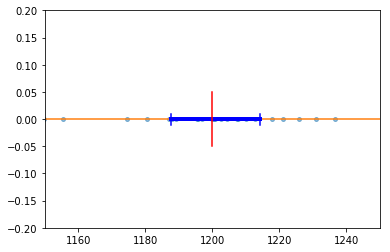

In [8]:
show_sample_and_ci(sample, ci, mu)

In [9]:
ci[0] <= mu <= ci[1]

True

What happens if we repeatedly sample and build a confidence interval?

In [10]:
btn = widgets.Button(description="Once again!")
out = widgets.Output()

def sample_and_compute(b):
    sample = population['Martian height'].sample(30)
    ci = ci_mu_norm(sigma, 0.05, sample)
    with out:
        clear_output()
        show_sample_and_ci(sample, ci, mu)

btn.on_click(sample_and_compute)
sample_and_compute(btn)
widgets.VBox([btn, out])

VBox(children=(Button(description='Once again!', style=ButtonStyle()), Output()))

We can now give a frequentistic interpretatation of the event

$$\bar X +\chi_{\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}} <
    \mu < \bar X - \chi_{\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

In [11]:
for _ in range(100):
    sample = population['Martian height'].sample(30)
    ci = ci_mu_norm(sigma, 0.05, sample)
    if not ci[0] <= mu <= ci[1]:
        print(ci)

(1171.1056656200208, 1197.5857389470348)


Thus $\delta$ represents the average number of times, in a long run, that the confidence interval does not contain the parameter to be inferred.

Advantage of the interval-based estimate over the point-based one:

- the interval length gives an idea of the indetermination,
- it obviously depends on the distribution under study and on sample size.

In [12]:
def ci_vs_sample_size(n):
    sample = population['Martian height'].sample(n)
    ci = ci_mu_norm(sigma, 0.05, sample)
    show_sample_and_ci(sample, ci, mu)

sizeSlider = widgets.IntSlider(
    value = 30,
    min = 10,
    max = 205,
    step = 5,
    description = 'Sample size',
    continuous_update = True
)

interact(ci_vs_sample_size, n=sizeSlider);

interactive(children=(IntSlider(value=30, description='Sample size', max=205, min=10, step=5), Output()), _dom_classes=('widget-interact',))

In a real-world scenario $\sigma$ is not known. Thus, instead of

$$\frac{\bar X - \mu}{\frac{\sigma}{\sqrt{n}}}$$

use

$$\frac{\bar X - \mu}{\frac{S}{\sqrt{n}}},$$

$S$ being the sample standard deviation, defined by

$$
S^2 = \frac{1}{n-1} \sum_{i=1}^n \left( X_i - \bar X \right)^2
$$

## Question

Is the resulting statistic still normal?

## Short answer

No.

## Long answer

Let's collect some thousand samples of 4 normal-distributed values, compute the corresponding values of $s$, normalize them, and plot the resulting empirical cumulative distribution function against those of a standard normal.

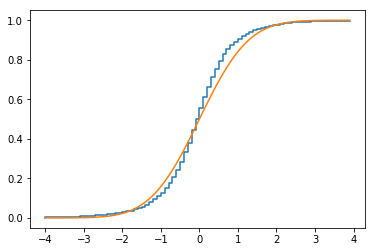

In [22]:
def t_stat(sample):
    x_bar = sample.mean()
    s = sample.std()
    return x_bar / s * len(sample)**0.5

Z = st.norm()
n = 5000
samples = np.split(Z.rvs(4*n), n)
t_vals = np.array(list(map(t_stat, samples)))
normalized_t_vals = (t_vals-t_vals.mean()) / t_vals.std()

import statsmodels.api as sm

ecdf = sm.distributions.ECDF(normalized_t_vals)
x = np.arange(-4, 4, 0.1)
y = ecdf(x)
plt.step(x, y)
plt.plot(x, Z.cdf(x))
plt.show()

The obtained distribution recalls a standard normal one, albeit with the probability mass much more distributed around the mean value.

To have a more precise answer, we can run a normality test on the obtained values:

In [14]:
from scipy.stats import normaltest

normaltest(normalized_t_vals).pvalue

0.0

the result is extremely below any reasonable threshold allowing us to accept the normality hypothesis.

However, there is a good news: it can be shown that

$$\frac{\bar X - \mu}{\frac{S}{\sqrt{n}}}$$

follows a known distribution, namely the _t distribution_ with $n-1$ degrees of freedom ($n$ being the sample size).

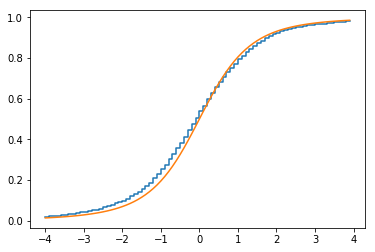

In [15]:
T = st.t(3)
ecdf = sm.distributions.ECDF(t_vals)
x = np.arange(-4, 4, 0.1)
y = ecdf(x)
plt.step(x, y)
plt.plot(x, T.cdf(x))
plt.show()

Let's compare the density of t distributions with different degrees of freedon with that of the standard gaussian distribution. 

In [16]:
def t_graph(n):
    T = st.t(n)
    Z = st.norm()
    xs = np.arange(-4, 4, 0.1)
    plt.plot(xs, T.pdf(xs))
    plt.plot(xs, Z.pdf(xs), alpha=0.4, c='b', linewidth=3)
    plt.ylim(0, 0.4)
    plt.show()

interact(t_graph, n=widgets.IntSlider(
    value = 4,
    min = 1,
    max = 30,
    description = 'Degrees of freedom',
    continuous_update = True
));

interactive(children=(IntSlider(value=4, description='Degrees of freedom', max=30, min=1), Output()), _dom_classes=('widget-interact',))

Computing a confidence interval when $\sigma$ is unknown is just a matter of replacing $\sigma$ with $s$ and the quantiles of a standard normal distribution with those of a t distribution with $n-1$ degrees of freedom.

In [17]:
delta = 0.1
x_bar = sample.mean()
s = sample.std()
n = len(sample)
T = st.t(n-1)
chi = T.ppf(delta/2)
confidence_interval = (x_bar + chi * s / math.sqrt(n),
                       x_bar - chi * s / math.sqrt(n))
print(confidence_interval)

(1185.5954473424642, 1208.7141511207508)


## Sample size analysis

The width of a confidence interval naturally identifies with the _uncertainty_ of the estimate. It is often necessary to provide a maximal width, that is an upper bound on uncertainty, at the price of selecting additional samples. For instance, the length of a confidence interval for the mean of a normal population having known variance $\sigma^2$ is

$$ 2\frac{\chi_{\frac{\delta}{2}}\sigma}{\sqrt{n}}, $$

thus if an upper bound $e$ on this lenght is envisaged, it is easy to see that

$$ 2\frac{\chi_{\frac{\delta}{2}}\sigma}{\sqrt{n}} \leq e $$

if and only if

$$ n \geq \left( \frac{2\chi_{\frac{\delta}{2}}\sigma}{e} \right)^2. $$

Let's compute the minimal sample size ensuring a 0.95 confidence interval whose width is smaller than 10.

In [20]:
delta = 0.05
chi = Z.ppf(delta/2)
e = 10

n_min = int((2*chi*sigma/e)**2)+1
print(n_min)

211


We can easily verify that this sample size gives rise to a confidence interval of the required width.

In [21]:
ci_mu_norm(sigma, delta, population['Martian height'].sample(n_min))

(1191.730862776704, 1201.7156446810975)

## Confidence intervals for the mean of generic distributions

Consider now the generic case of a sample $X_1, \dots, X_n$ drawn from a population $X$ whose distribution has expected value and variance equal to $\mu$ and $\sigma^2$, respectively, yet it is not normal. According to the central limit theorem, $\sum_{i=1}^n X_i$ approximately follows a Gaussian distribution having mean $\mu$ and standard deviation $\sigma\sqrt{n}$ (the higher $n$, the better the approximation), as exemplified by the following animation, where the empirical cumulative distibution of the sum of exponential distributions is plotted against the expected normal one.

In [146]:
def central_limit_th(n):
    num_samples = 1000
    U = st.expon()
    sum_vals = list(map(sum,
                        np.split(U.rvs(n * num_samples),
                                 num_samples)))

    N = st.norm(n*U.mean(), (n*U.var())**0.5)

    ecdf = sm.distributions.ECDF(sum_vals)
    x = np.arange(n*U.mean()-3*(n*U.var())**0.5,
                  n*U.mean()+3*(n*U.var())**0.5,
                  0.01)
    y = ecdf(x)
    plt.step(x, y)
    plt.plot(x, N.cdf(x))
    plt.show()

interact(central_limit_th, n=widgets.IntSlider(
    value = 4,
    min = 1,
    max = 30,
    description = 'Sample size',
    continuous_update = True
));

interactive(children=(IntSlider(value=4, description='Sample size', max=30, min=1), Output()), _dom_classes=('widget-interact',))

Analogously,

$$\frac{\bar X - \mu}{\frac{\sigma}{\sqrt{n}}}$$

will follow a Gaussian distribution, and thus the above mentioned techniques can be applied in order to find confidence intervals for $\mu$.

## Formalization: bilateral and unilateral confidence intervals

- Given a sample $X_1, \dots, X_n$ from a distribution dependent on an unknown quantity $\tau$,
- let $T_{\mathrm{low}}= t_{\mathrm{low}}(X_1, \dots, X_n)$ and $T_{\mathrm{high}}=t_{\mathrm{high}}(X_1, \dots, X_n)$ denote two statistics
- if
  - $T_{\mathrm{low}} \leq T_{\mathrm{high}}$
  - $\mathrm P(T_{\mathrm{low}} \leq \tau \leq T_{\mathrm{high}}) = 1 - \delta$
  - $\delta$ does not depend on $\tau$

  $(T_{\mathrm{low}}, T_{\mathrm{high}})$ is called a $1 - \delta$ (bilateral) confidence interval for $\tau$ (as well as its specifications $(t_{\mathrm{low}}, t_{\mathrm{high}})$.
  
Analogously, if alternatively

- $\mathrm P(\tau \leq T_{\mathrm{high}}) = 1 - \delta$
- $\mathrm P(\tau \geq T_{\mathrm{low}}) = 1 - \delta$

$(-\infty, T_{\mathrm{high}})$ or $(T_{\mathrm{low}}, +\infty)$ is a $1 - \delta$ _unilateral_ confidence interval for $\tau$.

The procedure previously used can be easily adapted to unilateral confidence intervals for the mean of a gaussian distribution: as

$$ \mathrm P \left(Z < \chi_{1-\delta} \right) = 1-\delta,$$

and

$$ \mathrm P\left(
     \mu < \bar X - \chi_{1-\delta} \frac{\sigma}{\sqrt{n}}
   \right) = 1-\delta,$$
  
it follows that

$$ \left(-\infty,
     \bar X - \chi_{1-\delta} \frac{\sigma}{\sqrt{n}}
   \right) $$

is a $1-\delta$ unilateral confidence interval for $\mu = \mathcal E(X)$.

In [71]:
sample = population['Martian height'].sample(100)

Z = st.norm()
x_bar = sample.mean()
chi = Z.ppf(1-delta)
n = len(sample)
ci_upper_bound = x_bar + chi * sigma / math.sqrt(n)

print(ci_upper_bound)

1203.95150935


Recall that $\mu = 1200$.

## Search of generic confidence intervals: pivotal quantities

A _pivotal quantity_ is a function of the sample such that the resulting distribution does not depend on the unknown quantity we are building the confidence interval for.

### Example: confidence interval for the variance

Let $X$ denote a normal population whose mean $\mu$ an variance $\sigma^2$ are unknown. It can be shown that

$$ Q = \frac{\sum_{i=1}^n \left(X_i - \bar X\right)^2}{\sigma^2}
     = \frac{(n-1)S^2}{\sigma^2}$$

follows a chi-square distribution with $n-1$ degrees of freedom, which is independent from $\sigma^2$ and as such can be used as a pivotal quantity.

Let $q_{\mathrm{low}}$ and $q_{\mathrm{high}}$ denote two values such that

$$\mathrm P \left(q_{\mathrm{low}} \leq Q \leq q_{\mathrm{high}}\right) = 1 - \delta.$$

As the former equation is equivalent to

$$\mathrm P \left(\frac{(n-1)S^2}{q_{\mathrm{high}}} \leq \sigma^2 \leq \frac{(n-1)S^2}{q_{\mathrm{low}}}\right) = 1 - \delta,$$

$$ \left(\frac{(n-1)S^2}{q_{\mathrm{high}}}, \frac{(n-1)S^2}{q_{\mathrm{low}}}\right) $$

is a $1-\delta$ bilateral confidence interval for $\sigma^2$.

### Problem ###

How $q_{\mathrm{low}}$ and $q_{\mathrm{high}}$ may be chosen? Easiest way: in such a way that $\mathrm P(Q \leq q_{\mathrm{low}}) = \frac{\delta}{2}$ and $\mathrm P(Q \geq q_{\mathrm{high}}) = \frac{\delta}{2}$.

We can use this result in order to compute, for instance, a 0.9 confidence interval for the variance of our original dataset.

In [69]:
n = 100
sample = population['Martian height'].sample(n)
C = st.chi2(n-1)

delta = 0.1

q_low = C.ppf(delta/2)
q_high = C.ppf(1-delta/2)

s_2 = sum((sample - sample.mean())**2)

(s_2 / q_high, s_2 / q_low)

(1190.9134921719781, 1904.7055875961098)

We can also easily verify that the interval is compatible with the estimated parameter:

In [65]:
sigma**2

1369

### Some biblographic references

- Sheldon M. Ross, Introduction to Probability and Statistics for Engineers and Scientists, 5th Edition, Academic Press, 2014
- Alexander M. Mood, Franklin A. Graybill, Duane C. Boes, Introduction to the theory of Statistics, 3rd Edition, McGraw-Hill, 1950